In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import graph_analysis, data_preprocessing

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Examining structural connectivity in neonates at genetic risk for schizophrenia

According to this [paper](https://www.sciencedirect.com/science/article/pii/S1053811912005149?via%3Dihub), there is some difference in the network measure properties between high risk and low risk neonates.

Here, I applied similar analysis to the high/low risk to see if we can reach similar conclusion

Upon computing the inter-regional GM structural associations and WM fiber connections, we constructed morphological networks and white matter networks for both high-risk and low-risk neonates. Graph-theoretic network analysis was then applied for analysis of these networks to determine between group differences. Network property metrics such as **clustering coefficient, path length, network efficiency, small- worldness, and centrality** were computed for comparison purposes.

* ***clustering coefficient***= measures the whole brain segregation, is the average of the absolute clustering coefficient of all nodes.
* ***shortest absolute path length***= measures the whole brain functional integration, is the average of the shortest absolute path lengths between the nodes.
* ***Small world network*** has a similar absolute path lengths but higher absolute clustering coefficients than those of random networks with the same number of nodes and edges, which can be represented by the two parameters, namely normalized clustering and normalized path length.

Statistical analysis used in the paper: 
A non-parametric permutation test was employed to assess the statistical difference of brain network properties between two groups. First a network property measure was computed separately for two groups of neonates. Then they randomly assigned the regional cortical of each subject to either group. Corr matrix was recomputed for each of the 2 randomized groups, and a new value for the network property was measure and obtained. This procedure was repeated 1000 times and signifiance is reached if less than 5% of between group difference in the permutation distribution was greater than the observed group difference. This procedure was repeated for each sparsity threshold

### 1. Volumetric dataset

#### 1.1 Data preprocessing

Here I use only the GM structural information, 51 variables. Absolute values of the correlations were taken as indicators of connections. 

In [3]:
# importing the preprocessed data
adjusted_european_GM_structural_schizophrenia=np.load('./preprocessed_data/adjusted_european_GM_structural_schizophrenia.npy')
structural_GM_labels=np.load('./preprocessed_data/structural_GM_labels.npy',allow_pickle=True)
european_prs_schizophrenia=np.load('./preprocessed_data/european_prs_schizophrenia.npy',allow_pickle=True)

In [4]:
#Dividing the data set into high and low risk
#get the indices of the low and high risk
low_risk,high_risk=data_preprocessing.high_low_risk_divide(european_prs_schizophrenia[:,5],bins=100,percentage=0.3)
X_low_risk=adjusted_european_GM_structural_schizophrenia[low_risk,:]
X_high_risk=adjusted_european_GM_structural_schizophrenia[high_risk,:]
X=np.vstack((X_low_risk,X_high_risk))
X=StandardScaler().fit_transform(X)
y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

In [67]:
np.save('./preprocessed_data/high_low_risk_vol_dataset.npy',X)

#### 1.2. Visualising data

In [5]:
#rearrange the matrix by side
right_indices=np.array([idx for idx,i in enumerate(structural_GM_labels) if 'right' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(structural_GM_labels) if 'left' in i])
print(left_indices.shape)
neither_indices=np.array([idx for idx,i in enumerate(structural_GM_labels) if 'right' not in i and 'left' not in i])
rearrange_by_side_indices=np.concatenate((right_indices,left_indices,neither_indices),axis=0)

(25,)
(25,)


In [6]:
# calculating pearson correlation matrix of volumetric data
corrmatrix_low_risk=abs(np.corrcoef(X[y==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk,0)
corrmatrix_high_risk=abs(np.corrcoef(X[y==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk,0)

In [7]:
rearranged_corrmatrix_low_risk=np.asarray([[corrmatrix_low_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk=np.asarray([[corrmatrix_high_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

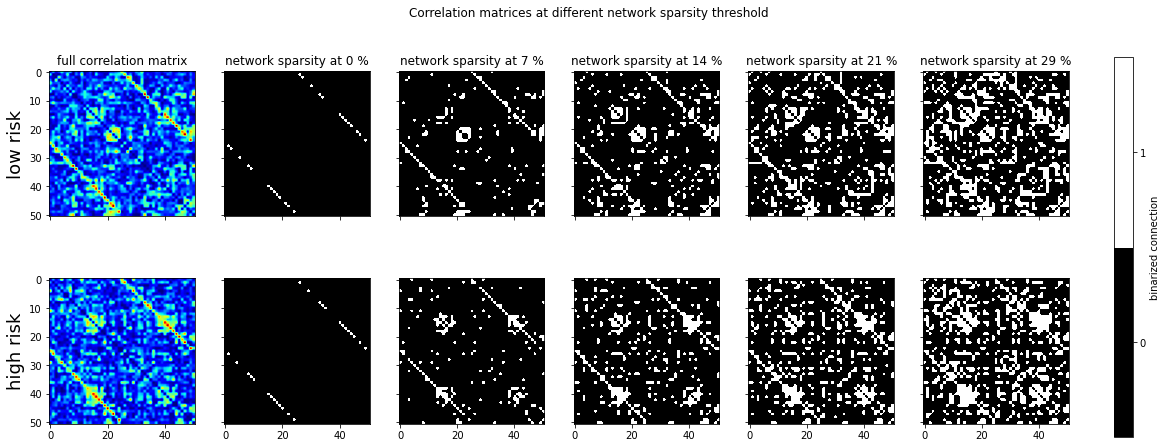

In [9]:
f,axes=plt.subplots(2,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(1,30,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(data_preprocessing.lower_triangle(binarized_matrix)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk,cmap='jet')
        ax.set_ylabel('high risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Correlation matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

#### 1.3. Network Metrics

In [10]:
#generate binarized matrices for over a range of network sparsity for high and low risk groups
binarized_low_risk_matrices=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices=np.asarray([data_preprocessing.lower_triangle(graph_analysis.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk,network_sparsity_threshold/100,bins=100)) for network_sparsity_threshold in np.linspace(1,30,30)])


In [46]:
#calculating graph_metrics_low_risk
import tqdm

for threshold in tqdm.tqdm(range(30)):
    temp_path_low_risk='./preprocessed_data/graph_metrics_vol_low_risk.txt'
    low_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_low_risk_matrices[threshold],51))

    with open(temp_path_low_risk,'ab') as f:
        np.savetxt(f,np.asarray([low_risk_metrics]),delimiter='\t')

    temp_path_high_risk='./preprocessed_data/graph_metrics_vol_high_risk.txt'
    high_risk_metrics=graph_analysis.calculate_network_metrics_random_volumetric_data(data_preprocessing.reverse_lower_triangle(binarized_high_risk_matrices[threshold],51))

    with open(temp_path_high_risk,'ab') as n:
        np.savetxt(n,np.asarray([high_risk_metrics]),delimiter='\t')

100%|██████████| 30/30 [02:47<00:00,  5.59s/it]


#### 1.4 Permutation statistics

check for significance difference, it is reached if less than 5 percentile of between-group difference in the permutation distribution was greater than the observed group difference.

Here, I performed two-tailed test taking the absolute difference. 

In [3]:
#run executable_script/perm_graph_network.py to calculate 1000 permuted network metrics.
obsv_high=np.loadtxt('./preprocessed_data/graph_metrics_vol_high_risk.txt')
obsv_low=np.loadtxt('./preprocessed_data/graph_metrics_vol_low_risk.txt')

In [4]:
import glob
perm_high,perm_low=graph_analysis.preprocess_perm_graph_results(high_risk=sorted(glob.glob('./log/*high*run*')),low_risk=sorted(glob.glob('./log/*low*run*')))

the two list do not have the same length: ./log/perm_graph_metrics_high_risk_vm2_run1.txt and ./log/perm_graph_metrics_low_risk_vm2_run1.txt


In [5]:
#the data is saved in the shape (1004,30,5).
np.save('./preprocessed_data/perm_vol_high_risk.npy',perm_high)
np.save('./preprocessed_data/perm_vol_low_risk.npy',perm_low)

In [5]:
p_value_matrix=graph_analysis.calculate_perm_p_value(obsv_high,obsv_low,perm_high,perm_low)

In [6]:
sig_indices_local_eff=np.where(p_value_matrix[:,0]<=0.025)[0]
sig_indices_global_eff=np.where(p_value_matrix[:,1]<=0.025)[0]
sig_indices_clus_eff=np.where(p_value_matrix[:,2]<=0.025)[0]
sig_indices_path_eff=np.where(p_value_matrix[:,3]<=0.025)[0]
sig_indices_small_eff=np.where(p_value_matrix[:,4]<=0.025)[0]

In [10]:
sig_indices_small_eff

array([ 0,  5, 12, 13, 14, 15])

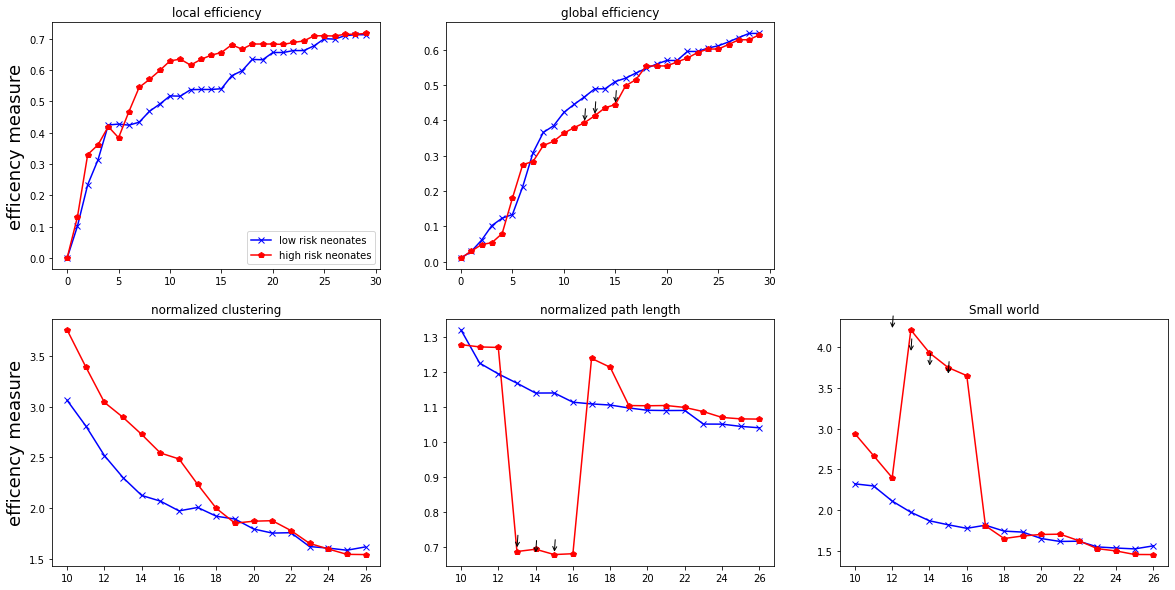

In [9]:
##############LOCAL EFFICIENCY############################
f,axes=plt.subplots(2,3,figsize=(20,10))
axes[0][0].plot(obsv_low[:,0],'x-',color='blue',label='low risk neonates')
axes[0][0].plot(obsv_high[:,0],'p-',color='red',label='high risk neonates')
for idx in sig_indices_local_eff:
    axes[0][0].annotate(' ',xy=(idx,obsv_high[:,0][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[0][0].legend(loc='bottom right')
axes[0][0].set_title('local efficiency')
axes[0][0].set_ylabel('efficency measure',fontsize=18)
##############GLOBAL EFFICIENCY############################
axes[0][1].plot(obsv_low[:,1],'x-',color='blue',label='low risk neonates')
axes[0][1].plot(obsv_high[:,1],'p-',color='red',label='high risk neonates')
for idx in sig_indices_global_eff:
    axes[0][1].annotate(' ',xy=(idx,obsv_high[:,1][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[0][1].set_title('global efficiency')
# axes[0][1].set_ylabel('efficency measure',fontsize=18)
##############NORMALIZED CLUSTERING############################
axes[1][0].plot(np.linspace(10,26,17),obsv_low[9:26,2],'x-',color='blue',label='low risk neonates')
axes[1][0].plot(np.linspace(10,26,17),obsv_high[9:26,2],'p-',color='red',label='high risk neonates')
for idx in sig_indices_clus_eff:
    if idx==0:
        continue
    axes[1][0].annotate(' ',xy=(idx,obsv_high[:,2][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
axes[1][0].set_title('normalized clustering')
axes[1][0].set_ylabel('efficency measure',fontsize=18)
# ##############NORMALIZED PATH############################
axes[1][1].plot(np.linspace(10,26,17),obsv_low[9:26,3],'x-',color='blue',label='low risk neonates')
axes[1][1].plot(np.linspace(10,26,17),obsv_high[9:26,3],'p-',color='red',label='high risk neonates')
for idx in sig_indices_path_eff:
    if idx==0:
        continue
    axes[1][1].annotate(' ',xy=(idx,obsv_high[:,3][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[1][1].set_title('normalized path length')
# axes[1][1].set_ylabel('efficency measure',fontsize=18)
##############SMALL WORDNESS############################
axes[1][2].plot(np.linspace(10,26,17),obsv_low[9:26,4],'x-',color='blue',label='low risk neonates')
axes[1][2].plot(np.linspace(10,26,17),obsv_high[9:26,4],'p-',color='red',label='high risk neonates')
for idx in sig_indices_small_eff:
    if idx==0:
        continue
    axes[1][2].annotate(' ',xy=(idx,obsv_high[:,4][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
# axes[0][1].legend(loc='bottom right')
axes[1][2].set_title('Small world')
# axes[1][2].set_ylabel('efficency measure',fontsize=18)

f.delaxes(ax=axes[0,2])

The paper also found that high-risk neonates have significantly lower global efficiency and higher local efficiency.

### 2. Diffusion dataset

#### 2.1 Data preprocessing

In [35]:
adjusted_european_connectivity_schizophrenia=np.load('./preprocessed_data/adjusted_european_connectivity_schizophrenia.npy',allow_pickle=True)
european_prs_schizophrenia=np.load('./preprocessed_data/european_prs_schizophrenia.npy',allow_pickle=True)
combinations_without_zeros=np.load('./preprocessed_data/combinations_without_zeros.npy',allow_pickle=True)
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [36]:
low_risk,high_risk=data_preprocessing.high_low_risk_divide(european_prs_schizophrenia[:,5],bins=100,percentage=0.3)
X_low_risk=adjusted_european_connectivity_schizophrenia[low_risk,:]
X_high_risk=adjusted_european_connectivity_schizophrenia[high_risk,:]
X=np.vstack((X_low_risk,X_high_risk))
X=StandardScaler().fit_transform(X)
y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

In [71]:
z=zip([idx for idx, i in enumerate(data_preprocessing.lower_triangle(ROIs_combinations)) if i in combinations_without_zeros],np.arange(X.shape[1]))
X_n=np.zeros((X.shape[0],4005))
while True:
    try:
        i,n=next(z)
        X_n[:,i]=X[:,n]
    except StopIteration:
        break

In [83]:
X_mean_connectivity_low_risk=np.mean(X_n[y==0],axis=0)
X_mean_connectivity_high_risk=np.mean(X_n[y==1],axis=0)

#### 2.2 Data Visualisation

In [84]:
connectivity_regions=([(str.split(i,'_'))[0] for i in ROIs_combinations[:,0]])
right_indices=np.array([idx for idx,i in enumerate(connectivity_regions) if '.R' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(connectivity_regions) if '.L' in i])
print(left_indices.shape)
rearrange_by_side_indices=np.concatenate((right_indices,left_indices),axis=0)

(45,)
(45,)


In [85]:
X_mean_connectivity_low_risk=data_preprocessing.reverse_lower_triangle(X_mean_connectivity_low_risk)
X_mean_connectivity_high_risk=data_preprocessing.reverse_lower_triangle(X_mean_connectivity_high_risk)

In [86]:
rearranged_mean_connectivity_low_risk=np.asarray([[X_mean_connectivity_low_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_mean_connectivity_high_risk=np.asarray([[X_mean_connectivity_high_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

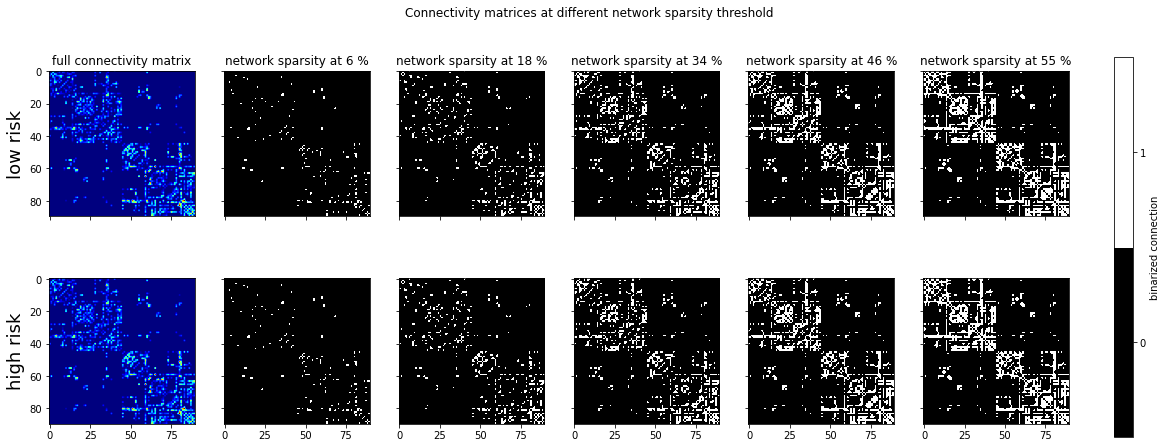

In [89]:
f,axes=plt.subplots(2,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(2,20,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(abs(rearranged_mean_connectivity_low_risk),cmap='jet')
        ax.set_title('full connectivity matrix')
        ax.set_ylabel('low risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(abs(rearranged_mean_connectivity_low_risk),network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(data_preprocessing.lower_triangle(binarized_matrix)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(abs(rearranged_mean_connectivity_high_risk),cmap='jet')
        ax.set_ylabel('high risk',fontsize=18)
    else:
        binarized_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(abs(rearranged_mean_connectivity_high_risk),network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Connectivity matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)